# Матрично-векторное дифференцирование. Практика

Данный семинар освещает следующие темы:
1. [Граф вычислений в библиотеке Pytorch](#Граф-вычислений-в-библиотеке-Pytorch)
2. [Численное приближение производных](#Численное-приближение-производных)


Для написания кода потребуются следующие библиотеки:

[numpy](https://numpy.org/), [pytorch >2.0](https://pytorch.org/), [autograd](https://github.com/HIPS/autograd), [matplotlib](https://matplotlib.org/)


In [ ]:
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from autograd import grad
%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

## Граф вычислений в библиотеке Pytorch

### Основы pytorch

Пройдёмся по основам - на самом деле, pytorch очень напоминает numpy:

In [ ]:
# numpy world
x = np.arange(16).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [ ]:
# pytorch world
x = np.arange(16).reshape(4, 4)

y = torch.from_numpy(x)
print('Type of y:', type(y))
y = torch.from_numpy(x).type(torch.FloatTensor)
print('Type of y', type(y))

Type of y: <class 'torch.Tensor'>
Type of y <class 'torch.Tensor'>


In [ ]:
x = torch.arange(0, 16).view(4, 4).float()
print('Type of x:', type(x))

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

Type of x: <class 'torch.Tensor'>
X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Отличия по операциям минимальны и легко находятся в [документации](https://pytorch.org/docs/stable/index.html) и google (Stackoverflow/tutorials):

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.LongTensor)
```
Можно преобразовать одно в другое

```
torch.from_numpy(npx) -- returns Tensor
tt.numpy() -- returns Numpy Array
```

#### In-place операции

Теперь мы работаем с тензорами, и ~~чаще всего~~ иногда они могут быть огромными.
Поэтому предусмотрена возможность in-place операций, что позволяет не создавать новый объект в памяти, а модифицировать существующий.
```
x.exp()   # not-in-place operation
x.exp_()  # in-place operation
```

In [ ]:
x = torch.arange(4).float()
print('Not-in-place:')
print('\tx.exp():\t\t', x.exp().numpy())
print('\tx:\t\t\t', x.numpy())
print('In-place:')
print('\tx.exp_():\t\t', x.exp_().numpy())
print('\tx after x.exp_():\t', x.numpy())

Not-in-place:
	x.exp():		 [ 1.         2.7182817  7.389056  20.085537 ]
	x:			 [0. 1. 2. 3.]
In-place:
	x.exp_():		 [ 1.         2.7182817  7.389056  20.085537 ]
	x after x.exp_():	 [ 1.         2.7182817  7.389056  20.085537 ]


In [ ]:
x = torch.arange(0, 4).view(2, 2)
y = torch.arange(4, 8).view(2, 2)
z = torch.arange(8, 12).view(2, 2)

# Not-in-place:
u = x + 2 * y - z    # 3 array allocations?
print(u.numpy())

# In-place
u = y.clone()        # 1 array allocation
u.mul_(2)
u.add_(x)
u.sub_(z)
print(u)

[[0 2]
 [4 6]]
tensor([[0, 2],
        [4, 6]])


#### Broadcasting в pytorch

In [ ]:
a = torch.Tensor([1, 1, 1, 2]).view(4, 1)
b = torch.Tensor([1, 0, 1, 0]).view(1, 4)
c = torch.randn(16).view(4, 4)
print('a:', a)
print('b:', b)
print('a + b:', a + b)
print('c:', c)
print('b + c:', b + c)

a: tensor([[1.],
        [1.],
        [1.],
        [2.]])
b: tensor([[1., 0., 1., 0.]])
a + b: tensor([[2., 1., 2., 1.],
        [2., 1., 2., 1.],
        [2., 1., 2., 1.],
        [3., 2., 3., 2.]])
c: tensor([[ 1.5950,  1.9406,  0.8462, -1.1511],
        [-0.7178, -0.2175, -0.7837,  0.6974],
        [-0.9859,  0.1516, -0.9798, -0.2008],
        [-0.4842, -0.8276, -0.2040,  0.5442]])
b + c: tensor([[ 2.5950,  1.9406,  1.8462, -1.1511],
        [ 0.2822, -0.2175,  0.2163,  0.6974],
        [ 0.0141,  0.1516,  0.0202, -0.2008],
        [ 0.5158, -0.8276,  0.7960,  0.5442]])


Для подробностей см. http://pytorch.org/docs/master/notes/broadcasting.html

### Построение графа вычислений

А теперь поговорим о том, для чего мы тут и собрались)

Концептуально, autograd хранит запись данных (тензоров) и всех выполненных операций (вместе с результирующими новыми тензорами) в ориентированном ациклическом графе (DAG), состоящем из объектов Function_.
В этом DAG *листья* -  входные тензора, *корни* - выходные. Благодаря полному пути от листьев к корням можно вычислить по chain-rule требуемые градиенты.

При **forward** проходе autograd делает две вещи одновременно:

- выполняет запрошенную операцию для вычисления результата в тензор
- поддерживает функцию градиента операции в DAG.

**Backward** проход начинается, когда функция *.backward()* вызывается в корне DAG. тогда autograd:

- вычисляет градиенты из каждого .grad_fn,
- накапливает их в атрибуте .grad соответствующего тензора
- используя chain rule, распространяется вплоть до конечных тензоров.

Давайте построим данный граф вычислений:

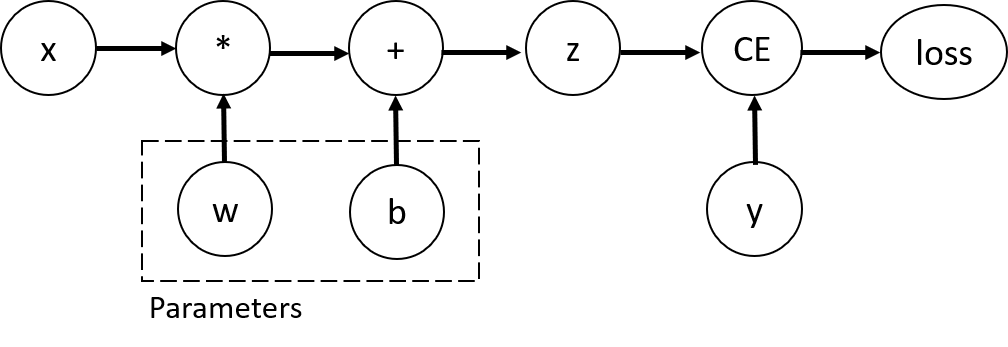

In [ ]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

Как и говорилось ранее, для каждого объекта Function сохраняется и grad_fn при *backpropagation*.

Для более сложных примеров chain-rule на графе вычислений можно посмотреть [CSC321](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec06.pdf)

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x79aacba794b0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x79aacba7bb80>


**Для того, чтобы вычислить градиенты вызывается .backward() проход от скалярного корня**

In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

RuntimeError: ignored

По умолчанию, все переменные с ``requires_grad=True`` отслеживаются для вычисления градиента в дальнейшем. Чтобы перестать отслеживать выполняемые с ними операции можно использовать режим ``.no_grad()``

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Также можно применить метод ``detach()`` к тензору

In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


Тензоры, которые требуют подсчёт градиента, нельзя перевести в numpy arrray.

In [ ]:
w.numpy()

RuntimeError: ignored

Это может потребоваться при:
  - Обучении нейронных сетей, чтобы заморозить часть параметров.
  - Оптимизации скорости вычисления. Поскольку для этих переменных будет осуществляться только forward

Также **важно запомнить**, что граф накапливает градиенты при вызове backward(). Поэтому важно не забывать об этом при оптимизации.

### Примеры функций и вектор-функций

В случае с вектор-функциями, pytorch использует **Jacobian product**, а не вычисляет градиент.

Для вектор-функции $\vec{y}=f(\vec{x})$, где
$\vec{x}=\langle x_1,\dots,x_n\rangle$ и
$\vec{y}=\langle y_1,\dots,y_m\rangle$, производная
$\vec{y}$ по $\vec{x}$ задаётся матрицей Якоби:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

Вместо вычисления матрицы Якоби, pytorch вычисляет **Jacobian Product** $v^T\cdot J$ для заданного входного вектора $v=(v_1 \dots v_m)$. Для этого подаём в ``backward`` аргумент. Размер аргумента должен быть равен размеру тензора, по которому берём производную

Флаг `retain_graph=True` позволяет вызывать backward от одного и того же тензора несколько раз. Со значением `False` Pytorch не позволит это сделать.

In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")

inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Кроме этого, для нелистовых переменных библиотека позволяет также сохранить градиенты с помощью ``retain_grad()``

In [ ]:
x = torch.randn(4)   # leaf variable
z = torch.randn(4)   # leaf variable
w = z * 2
# not a leaf variable
w.requires_grad = True
y = x * w + 1  # forward pass before retaining gradient is ok

p = y.sum()

y.retain_grad()

p.backward()
print('dp / dx:', x.grad)
print('dp / dz:', y.grad)
print('dp / dw:', w.grad)

dp / dx: None
dp / dz: tensor([1., 1., 1., 1.])
dp / dw: tensor([-1.7554, -1.2321,  0.9700, -1.2008])


In [ ]:
y.grad

<ipython-input-19-10b3a7061f6d>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  y.grad


### Давайте что-нибудь пооптимизируем

Вам дана некоторая ~~странная~~ функция потери, которая заставляет линейное преобразование отображать точки 10-мерного пространства в 2-мерный круг с радиусом 1. Вы должны использовать градиентный спуск по параметрам преобразования.

Линейное преобразование 10-мерной точки $x$ в 2-мерную точку $y$ имеет веса $W$ и $b$ и выглядит следующим образом:
$$y = Wx + b$$

Норма двумерного пространства Евклидова:
$$||y||_2 = \sqrt{y_1^2 + y_2^2}$$

Лосс функция $f_0$ штрафует точку $y$ за отдаление от окружности радиуса 1:
$$f_0(x, W, b) = 0.5 \cdot \big| ||y||_2 - 1 \big| + \big( ||y||_2 - 1 \big)^2$$

К сожалению, оптимизация по $f_0$ по $W$ и $b$ может быть осуществлена аналитически и выдаёт $W = 0$, $b = (1, 0)$.
Чтобы избежать такого решения, мы также наказываем за близость $y$ к $b$. Этот штраф обращается в $0$ если расстояние от $y$ до $b$ больше $1$:
$$f_1(x, W, b) = \max\big(0, \frac{1}{||y - b||_2} - 1\big)$$

Итоговая loss-функция выглядит следующим образом:
$$f(x, W, b) = f_0(x, W, b) + f_1(x, W, b)$$

Вам требуется решить следующую задачу оптимизации:
$$\frac{1}{N}\sum\limits_{i = 1}^N f(x_i, W, b) \to \min\limits_{W, b}$$

In [ ]:
X = torch.randn(50, 10)
b = torch.randn(2)
W = torch.randn(10, 2)

In [ ]:
def f(X, W, b):
    ### your code here ###

    ### Example of the implementation ###
    biased_y_norm = torch.norm(X.mm(W).add(b), dim=-1)
    return (0.5*torch.abs(biased_y_norm - 1) + (biased_y_norm - 1)**2 +
            torch.maximum(torch.zeros(X.size(0)), 1/torch.norm(X.mm(W), dim=-1) - 1)
           ).mean()


In [ ]:
print(f(X, W, b))

tensor(23.3531)


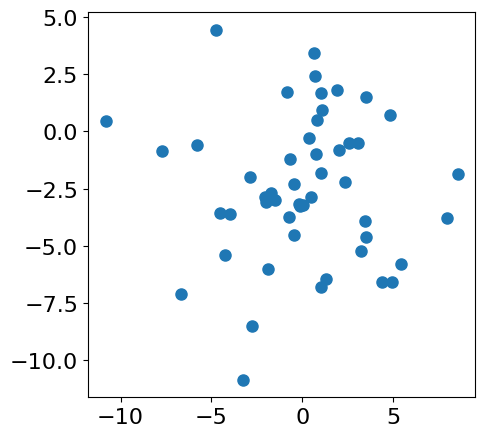

In [ ]:
plt.figure(figsize=(5, 5))
Y = X.mm(W).add(b)
plt.scatter(Y[:, 0], Y[:, 1]);

Базовая реализация градиентного спуска имеет вид


1.   Выбираем $W_0, b_0$
2.   $W_{k+1} = W_k - \gamma \nabla_W f(W,b)$
3.   $b_{K+1} = b_k - \gamma \nabla_b f(W,b)$

для некоторого фиксированного $\gamma > 0$



In [ ]:
### your code here ###

In [ ]:
gamma = 2e-1
max_iter = 15

b =
W =

for i in range(max_iter):
    loss = f(X, W, b)

    print(loss.item())

20.213945388793945
7.461338043212891
3.3986258506774902
1.8797916173934937
1.2322907447814941
0.9292768836021423
0.7531923055648804
0.6492284536361694
0.5909088253974915
0.5565641522407532
0.5341301560401917
0.5120980143547058
0.49914324283599854
0.487131804227829
0.47439810633659363


In [ ]:
# Такая реализация уже ближе к жизни
max_iter = 15
b =
W =
optimiser =

for i in range(max_iter):

    loss = f(X, W, b)

    print(loss.item())

16.491182327270508
4.170269966125488
1.7635501623153687
1.0441399812698364
0.7755373120307922
0.6696639060974121
0.6105453372001648
0.5705885887145996
0.5415941476821899
0.5218358635902405
0.5089248418807983
0.4982476830482483
0.48654693365097046
0.476439505815506
0.4714120030403137


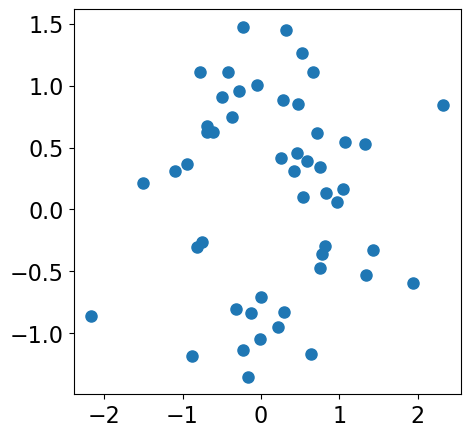

In [ ]:
plt.figure(figsize=(5, 5))
Y = X.mm(W.detach()).add(b.detach())
plt.scatter(Y[:, 0], Y[:, 1]);

#### Блок заданий на интерес

1. (Задание на интерес) Реализуйте (найдите простенькую реализацию) полносвязной нейронки. Поиграйтесь с optimisers Можно ли сделать кружочек идеальным?

2. Решите пазл с помощью pytorch. (Найдено [здесь](https://machinelearningmastery.com/using-autograd-in-pytorch-to-solve-a-regression-problem/))
```
[ A ]  +  [ B ]  =  9
  +         -
[ C ]  -  [ D ]  =  1
  =         =
  8         2
```

In [ ]:
# Решение
# Попробуйте выразить условия равенства через дифференцируемый лосс от отклонения от этого самого равенства

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1599.32it/s]

A=5.6899943351745605, B=3.3092551231384277, C=2.309516668319702, D=1.308767318725586
A + B = 9.00
A + C = 8.00
C - D = 1.00
B - D = 2.00


### Напоследок. Как достать матрицы Гессе и Якоби?

Pytorch, кроме вычисления Jacobian product, позволяет и напрямую доставать матрицу Якоби и Гессе.

Рассмотрим на простой функции, как это сделать:

In [ ]:
def exp_adder(x, y):
    return 2 * x.exp() + 3 * y

inputs = (torch.rand(1), torch.rand(1)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.9677]), tensor([0.0405]))


(tensor([[5.2636]]), tensor([[3.]]))

Первый выход должен быть равен $2e^x$, а второй -  3.

**Естественно, это можно проделать и с тензорами большего порядка**

In [ ]:
inputs = (torch.rand(3), torch.rand(3)) # arguments for the function
print(inputs)
torch.autograd.functional.jacobian(exp_adder, inputs)

(tensor([0.4944, 0.7525, 0.2604]), tensor([0.2786, 0.7061, 0.6855]))


(tensor([[3.2791, 0.0000, 0.0000],
         [0.0000, 4.2446, 0.0000],
         [0.0000, 0.0000, 2.5950]]),
 tensor([[3., 0., 0.],
         [0., 3., 0.],
         [0., 0., 3.]]))

Метод ``torch.autograd.functional.hessian()`` для дважды дифференцируемой функции работает аналогично (вычисляя матрицу Гессе). Только функция должна возвращать одно число...

In [ ]:
def pow_adder_reducer(x, y):
    return (2 * x.pow(2) + 3 * y.pow(2)).sum()

inputs = (torch.rand(2), torch.rand(2))
torch.autograd.functional.hessian(pow_adder_reducer, inputs)

((tensor([[4., 0.],
          [0., 4.]]),
  tensor([[0., 0.],
          [0., 0.]])),
 (tensor([[0., 0.],
          [0., 0.]]),
  tensor([[6., 0.],
          [0., 6.]])))

Также можно напрямую вычислять произведение Якоби ($j$) на вектор ($v$) - vjp\jvp

In [ ]:
def do_some_doubling(x):
    y = x * 2
    while y.data.norm() < 1000:
        y = y * 2
    return y

inputs = torch.randn(3)
my_gradients = torch.tensor([0.1, 1.0, 0.0001])
torch.autograd.functional.vjp(do_some_doubling, inputs, v=my_gradients)

(tensor([ 981.1832, -350.0511, -810.3682]),
 tensor([1.0240e+02, 1.0240e+03, 1.0240e-01]))

Методы``vhp()`` и  ``hvp()`` считают произведения уже с матрицей Гессе.

Подробнее, можно посмотреть [документацию](https://pytorch.org/docs/stable/autograd.html#functional-higher-level-api)_




## Численное приближение производных и Autograd

Пусть $f: \mathbb{R}^d \rightarrow \mathbb{R}$ функция векторного аргумента. Из мат. анализа, мы понимаем, как найти *частную производную* (ч.п.)
$$\frac{\partial f(\dots, x_k, \dots)}{\partial x_k} = \lim\limits_{\Delta x \rightarrow 0} \frac{f(\dots, x_k + \Delta x, \dots) - f(\dots, x_k, \dots)}{\Delta x_k}$$
и составить из ч.п. *градиент*
$$\nabla f = \left\{\frac{\partial f}{\partial x_i}\right\}_{i=1}^d,$$
прогуляться в какое-то направление $\mathbf{e}$ с этой производной
$$\frac{\partial f}{\partial \mathbf{e}} = \sum\limits_{i=1}^d \frac{\partial f}{\partial x_i} \mathbf{e}_i = \langle \nabla f, \mathbf{e} \rangle$$
а потом и до матрицы *гессиана* не далеко
$$\nabla^2 f = \left[\frac{\partial^2 f}{\partial x_i \partial x_j}\right]_{i, j = 1}^{d, d}$$
~~Дальше запускаем GD/метод Ньютона и всё работает...~~

Но как реализовать вычисление всех этих чудес?

**В качестве примеров будем использовать следующие три функции:**
\begin{gather}
f_1(x, y) = x^2 + y^2 \\
f_2(x, y) = \sin(x^2)e^{-\frac{x^2 + y^2}{5}} \\
f_3(x, y) = \begin{cases}
             \frac{x^2 y}{x^2 + y^2}, & (x, y) \neq (0, 0)\\
             0, & (x, y) = (0, 0)
            \end{cases}\\
f_4(x, y) = \sqrt[3]{x^3 + y^3}
\end{gather}

Про **autograd** более подробно прочитать в презентации здесь -  [CSC321](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf).


Библиотека ``autograd`` работает с функциями от *numpy*-массивов и строит вычисление по следующему принципу: при вычислении функции (любой промежуточной в графе вычисления) библиотека обёртывает функцию в "коробку" для генерации полного графа вычислений

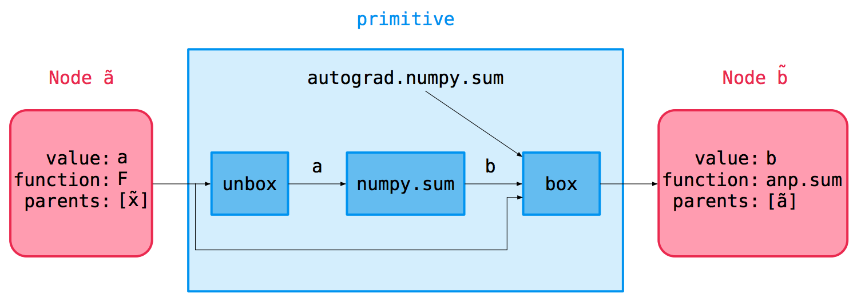

Поэтому стоит аккуратнее отнестить к заданию функции, от которой мы собираемся получить градиент:

- использовать специальные математические функции из самой библиотеки ``autograd`` (``import autograd.numpy as anp``)
- при умножении векторов/матриц также использовать операции либо чистого ``python`` (``@``),  либо также из библиотеки

В примере ниже, первая функция, написанная на чистом ``numpy`` не подойдёт для подсчёта градиента (метод grad() из библиотеки) с помощью этой библиотеки по многим причинам:
- основная - любую специальную мат. функцию надо брать из ``autograd.numpy``;
- само по себе применение ``.dot()`` из ``numpy`` безобидно (можно проверить, убрав mean), т.к. результатом операции будет *numpy.array* из одного float. Но стоит это иметь в виду, если это не последняя операция
- поскольку при добавлении ``mean()`` используется промежуточный подсчёт суммы перед делением (т.е. происходит подсчёт двух операций), что требует от ``autograd`` типа *ArrayBox* для аргумента (см. последнюю функцию)

In [ ]:
W = np.array([[1.5, 0],
              [0, 1.]
             ])
w = np.array([1.5, 0])

def logistic(x: np.ndarray):
    return 1./(1 + np.exp(-np.dot(x, W).mean()))

def logistic_1(x: np.ndarray):
    return 1./(1 + anp.exp(-(x @ W).mean()))

def logistic2(x: np.ndarray):
    print(type(x@W))
    return 1./(1 + anp.exp(-anp.mean(x@W)))

grad_example = grad(logistic2)
print(grad_example(np.zeros(2)))

<class 'autograd.numpy.numpy_boxes.ArrayBox'>
[0.1875 0.125 ]


Для понимания того, как вычисляются сами производные в библиотеках, использующих концепцию ``autodiff``, важно осознать, что они:
- не используют в явном виде разностные приближения (поскольку *forward pass* может быть тяжёлым)
- опираются на процедуру подсчёта функций/их градиентов, а не дифференциируют символьно


**Вместо этого,** , библиотеки используют вычисленные заранее произведения **vector-Jacobian** (коснёмся их ещё раз уже в pytorch) для  математических функций:

Для вектор-функции $\mathbf{y}=f(\mathbf{x})$, где
$\mathbf{x}=\langle x_1,\dots,x_n\rangle$ и
$\mathbf{y}=\langle \mathbf{y}_1,\dots,\mathbf{y}_m\rangle$, производная
$\mathbf{y}$ по $\mathbf{x}$ задаётся матрицей Якоби:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial \mathbf{y}_{1}}{\partial \mathbf{x}_{1}} & \cdots & \frac{\partial \mathbf{y}_{1}}{\partial \mathbf{x}_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial \mathbf{y}_{m}}{\partial \mathbf{x}_{1}} & \cdots & \frac{\partial \mathbf{y}_{m}}{\partial \mathbf{x}_{n}}
      \end{array}\right)\end{align}

Тогда вектор строка производной для конкретного вектора $\mathbf{\overline{x}}$ получается умножением $\mathbf{\overline{x}} = \mathbf{\overline{y}}^T \mathbf{J}$

Но матрицу Якоби не вычисляют при формировании графа вычисления. Используется именно это произведение. Продемострируем, например, для функции $\mathbf{y} = g(\mathbf{x}) = \exp(\mathbf{x})$.

Функция вычисления градиента *принимает* градиент с предыдущего узла $\mathbf{\overline{y}} = \mathbf{g}$, значение выхода $\mathbf{y} = \mathbf{ans}$ и входных аргументов  $\mathbf{x}$ и *выдаёт* входной градиент $\mathbf{\overline{x}}$.
Примеры из библиотеки:

```
defvjp(exp, lambda g, ans, x: ans * g)
defvjp(log, lambda g, ans, x: g / x)
defvjp(multiply, lambda g, ans, x, y: y * g,
                 lambda g, ans, x, y: x * g)
```

Выше использованы *лямбда-функции* - это термин из теории алгоритмов и функционального программирования. В ``python`` частично реализован аппарат ФП за счёт этих функций - они позволяют задать безымянные функции (в интерпретаторе можно вызвать как анонимную функцию) без внутренних переменных (что позволяет меньше использовать память и стэк, например.

Для больших примеров использования см., например, https://realpython.com/python-lambda/

In [ ]:
def f1(x: np.ndarray):
    return x.T @ x

def f2(x: np.ndarray):
    return anp.sin(x[0]**2) * anp.exp(-x.T @ x/5)

def f3(x: np.ndarray):
    norm2 = x.T @ x
    if norm2 == 0.:
        return 0.
    else:
        return x[0] * x[1]**2/ (x[0]**2 + x[1]**4)

def f4(x: np.ndarray):
    return (x[0]**3 + x[1]**3)**(1/3)

<ipython-input-39-2c48e8b3e193>:15: RuntimeWarning: invalid value encountered in double_scalars
  return (x[0]**3 + x[1]**3)**(1/3)


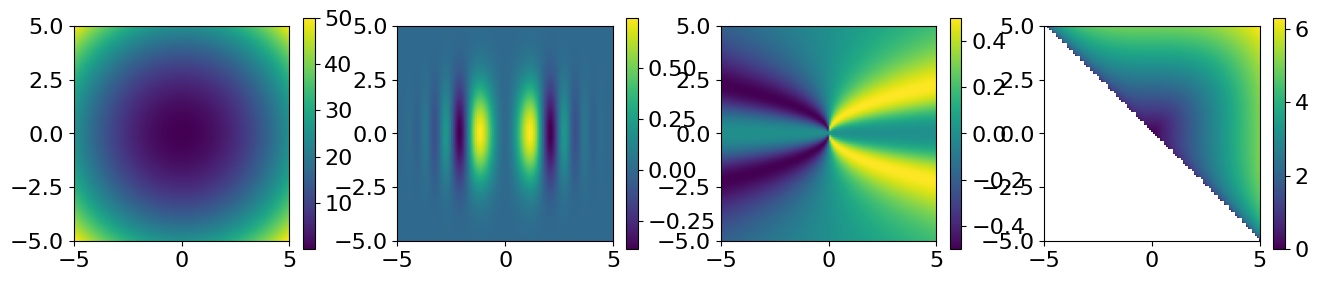

In [ ]:
_x = np.linspace(-5, 5, 100)
_y = np.linspace(-5, 5, 100)
X_mesh, Y_mesh = np.meshgrid(_x, _y)
coordinates = np.stack([X_mesh, Y_mesh]).reshape((2, -1))
funcs = [f1, f2, f3, f4]

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
for i, f in enumerate(funcs):
    img = axes[i].imshow(np.apply_along_axis(f, 0, coordinates).reshape((100, 100)),
                     extent=(-5, 5, -5, 5), origin='lower')
    fig.colorbar(img, ax=axes[i])

(Вопрос) Что мы ожидаем от 3 и 4 функции в рамках вычислений градиента, производных по направлению?

### **(Задание 1) Напишите код для подсчёта частных производных приведённых выше функций**

Вычислим частные производные по формуле:
\begin{equation}
\frac{\partial f}{\partial x_i} \approx \frac{f(\dots, x_i + \varepsilon, \dots) - f(\dots, x_i - \varepsilon, \dots)}{2\varepsilon}
\end{equation}

In [ ]:
def dfdx_i(f: callable,
           x: np.ndarray,
           i=0,
           eps=1e-3
          ):
    ### your code here ###



**В качестве проверки вашей реализации, посчитайте градиенты функции $f_1$ в точках (0, 0), (10, 0) и (5, 5).**

In [ ]:
# grad_f1_0 = # your code here
# grad_f1_10 = # your code here
# grad_f1_5 = # your code here


***Для проверки вашего решения, например, мы воспользуемся библиотекой autograd.***

Как и jax, она может вычислять градиенты и пр. от функций векторного аргумента из библиотеки numpy.

Поговорим об этом позже в jax (упомянули, чтобы знали и об этой, довольно популярной, библиотеке)

In [ ]:
from autograd import grad
assert np.allclose(grad_f1_0, grad(f1)(np.zeros(2)))
assert np.allclose(grad_f1_10, grad(f1)(np.array([10, 0.])))
assert np.allclose(grad_f1_5, grad(f1)(np.array([5, 5.])))

Размялись... Теперь задание посерьёзнее - пусть у нас есть точный градиент функции $f_2$.

In [ ]:
def true_grad_f2(x: np.ndarray):
    return np.array([np.exp(-x.T @ x/5) * (2*x[0]*np.cos(x[0]**2) - 0.4*np.sin(x[0]**2)*x[0]),
                     -np.sin(x[0]**2) * np.exp(-x.T @ x/5) * 0.4 * x[1]
                    ])

**Посчитайте для разных eps значение норму разности численного градиента и теоретического в точке (5., 2.)**

In [ ]:
grad_norms = []

_point = np.array([5, 2.])
# eps_range = ### your code here ###

for eps in tqdm(eps_range):
    ### your code here ###



100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:13<00:00, 7682.36it/s]


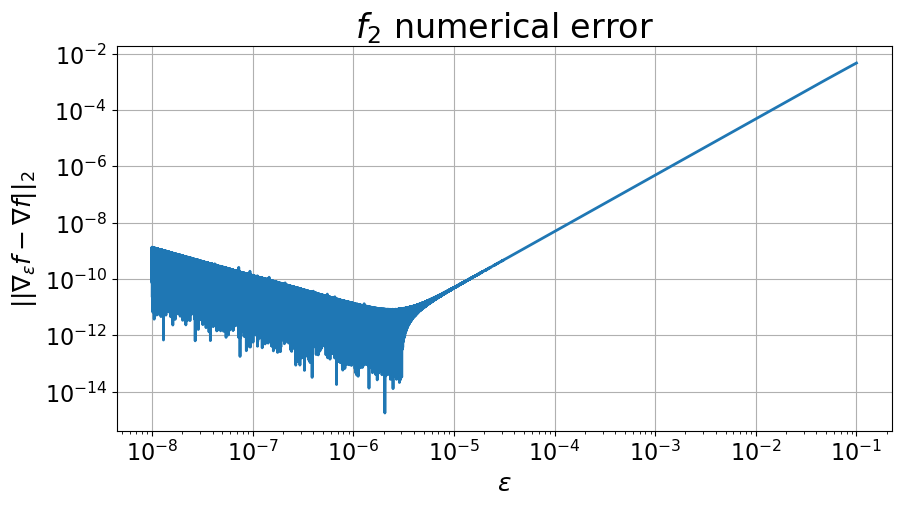

In [ ]:
plt.loglog(eps_range, grad_norms)
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\|| \nabla_{\varepsilon}f - \nabla f \||_2$")
plt.title(r"$f_2$ numerical error")
plt.grid();

***Вопросы к размышлению:***
- В чём причина такого поведения?
- Из-за чего такой рост в левом конце? Разве не логичнее брать шаг всё меньше и меньше?)
- Можно ли воспроизвести такое поведение с функцией $f_1$?

#### Ответы на вопросы)

Для более подробных ответов и 4-х точечных схем см. https://www.uio.no/studier/emner/matnat/math/MAT-INF1100/h09/kompendiet/chap11.pdf

Сначала на третий - "можно ли воспроизвести?"

Можно, но довольно непрактичным образом - нелогично, как кажется, брать сильно большой шаг.

In [ ]:
def true_grad_f1(x: np.ndarray):
    return 2*x

In [ ]:
grad_norms = []

_point = np.array([10, 5.])
eps_range = np.logspace(-4, 4, 100000)
for eps in tqdm(eps_range):
    grad_norms.append(np.linalg.norm(np.array([dfdx_i(f1, _point, i, eps=eps) for i in [0, 1]]) - true_grad_f1(_point)))

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:06<00:00, 15877.91it/s]


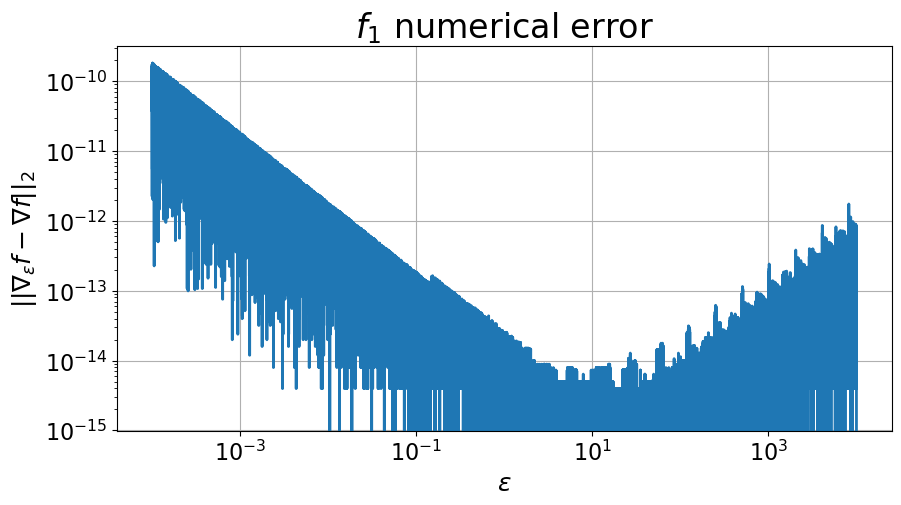

In [ ]:
plt.loglog(eps_range, grad_norms)
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\|| \nabla_{\varepsilon}f - \nabla f \||_2$")
plt.title(r"$f_1$ numerical error")
plt.grid();

**А в чём первопричина такого поведения?**

Рассмотрим разложение функции с приращением:
\begin{gather}
f(\mathbf{x} + \varepsilon \mathbf{e}) = f(\mathbf{x}) + \langle \nabla f(\mathbf{x}), \varepsilon \mathbf{e}\rangle + O(\varepsilon^2) \\
\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} + O(\varepsilon)
\end{gather}

Последнее выражение является формулой для вычисления производной по направлению $\mathbf{e}$.


Давайте оценим, какое $\varepsilon$ брать для точного вычисления?

**С точки зрения пределов логичнее брать $\varepsilon$ как можно меньше. НО нас ограничивает машинная точность - float не вытянет слишком малого значения(**

Пусть $fl(x)$ - представление вещественного числа в float формате, $\varepsilon_m$ - машинная точность. Тогда верно, что
$$|fl(x) - x| \leq \varepsilon_m |x|$$
Оценим, какая возможна минимальная ошибка между float-представлением градиента и его $\varepsilon$-вычислением:
\begin{gather}
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right| = \left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle + \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right) + \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} - \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right| \leq \\
\leq \underbrace{\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right|}_{\text{Не зависит от } \varepsilon} + \underbrace{\left|\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle - \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right|}_{\leq \frac{L_2}{2} \varepsilon} + \underbrace{\left|\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon} - fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right|}_{\text{При делении точность не теряется, отдельно берём дробь}} \leq \\
\leq const + \frac{L_2}{2} \varepsilon + \left|\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - fl\left(f(\mathbf{x} + \varepsilon \mathbf{e})\right) - (f(\mathbf{x}) - fl\left(f(\mathbf{x})\right))}{\varepsilon}\right| \leq \\
\leq const + \frac{L_2}{2} \varepsilon + \frac{L_0 \varepsilon_m + L_0 \varepsilon_m}{\varepsilon} = const + \frac{L_2}{2} \varepsilon + \frac{2 L_0 \varepsilon_m}{\varepsilon} \rightarrow \min_{\varepsilon}
\end{gather}

В этих обозначениях, $L_2$ - ограничение значения вторых производных в окрестности для любого направления $\mathbf{e}$ (свойство гладкости функции), $L_0$ - аналогичное ограничение функции.

Из минимизации, находим оптимальное $\varepsilon$ и ограничение сверху на ошибку представления:
\begin{gather}
\frac{L_2}{2} - \frac{1}{\varepsilon^2} 2 L_0 \varepsilon_m = 0 \Rightarrow \quad \varepsilon = 2\sqrt{\frac{L_0 \varepsilon_m}{L_2}} \approx \sqrt{\varepsilon_m} \\
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x})}{\varepsilon}\right)\right| \leq \frac{L_2}{2} 2\sqrt{\frac{L_0 \varepsilon_m}{L_2}} + \frac{2 L_0 \varepsilon_m}{2\sqrt{\frac{L_0 \varepsilon_m}{L_2}}} = \sqrt{L_0 L_2 \varepsilon_m} + \sqrt{L_0 L_2 \varepsilon_m} = 2\sqrt{L_0 L_2 \varepsilon_m}
\end{gather}

(OPTIONAL)
Мы же использовали симметричную схему, у неё меньше математическая погрешность аппроксимации. Для неё оценка следующая (шаги те же, можно показать разложением до $O(\varepsilon^3)$):
\begin{gather}
\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon} + O(\varepsilon^2) \\
\left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon}\right)\right| \leq \frac{L_3}{6}\varepsilon^2 + \frac{L_0 \varepsilon_m + L_0 \varepsilon_m}{2\varepsilon} \rightarrow \min_{\varepsilon} \\
\varepsilon = \sqrt[3]{\frac{3L_0 \varepsilon_m}{L_3}} \Rightarrow \quad \left|fl\left(\langle \nabla f(\mathbf{x}), \mathbf{e}\rangle\right) -  fl\left(\frac{f(\mathbf{x} + \varepsilon \mathbf{e}) - f(\mathbf{x} - \varepsilon \mathbf{e})}{2 \varepsilon}\right)\right| \leq \sqrt[3]{L_3 L_0^2 \varepsilon_m^2}\left(\frac{\sqrt[3]{9}}{6} + \frac{\sqrt[3]{9}}{3}\right) = \frac{\sqrt[3]{9 L_3 L_0^2 \varepsilon_m^2}}{2}
\end{gather}

**Итого: Причина поведения на графике (и отличия поведения $f_1$ и $f_2$) в:**
- Зависимости погрешности аппроксимации производных от машинной точности
- Ограниченности погрешности константами Липшецевости для вторых/третьих производных и самих значений функций

### **Задание 2. Производные по направлению. Комплексное разложение**

Вообще говоря, мы умеем делать комплексные разложения. Могут ли они нам помочь?

ДА!

\begin{gather}
f(\mathbf{x} + i\varepsilon \mathbf{e}) = f(\mathbf{x}) + \langle \nabla f(\mathbf{x}), i\varepsilon \mathbf{e}\rangle - \frac{1}{2} \langle\mathbf{e}, \nabla^2 f(\mathbf{x}) \mathbf{e}\rangle\varepsilon^2 + iO(\varepsilon^3) \\
Im(f(\mathbf{x} + i\varepsilon \mathbf{e})) = \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle \varepsilon + O(\varepsilon^3) \Rightarrow \langle \nabla f(\mathbf{x}), \mathbf{e}\rangle = \frac{Im(f(\mathbf{x} + i\varepsilon \mathbf{e}))}{\varepsilon} + O(\varepsilon^2)
\end{gather}

Эта оценка не содержит разностных схем, что позволяет улучшить оценку в случае приближения $\varepsilon$ к машинной точности.
Проиллюстрируем это на примере $f_2, f_3, f_4$.

**Используя код подсчёта градиента из прошлого задания, реализуйте вычисление градиента по направлению**

In [ ]:
def df_direction(f: callable,
                 x: np.ndarray,
                 e: np.ndarray,
                 eps=1e-3
                ):
    ### your code here ###



**Сравните для разных $\varepsilon$ результаты вашей реализации и комплексного приближения (код ниже) на единичном направлении с теоретическим градиентом функции $f_2$**

Для справки: в ``python`` реализован механизм работы с комплексными числами. Для этого зарезервирована переменная мнимой единицы `1j` и у таких чисел есть атрибуты `real`, `imag`.

Библиотека `numpy`, в продолжение, позволяет оперировать комплексными векторами и вычислять от них функции (также есть и `np.real`, `np.imag`).

In [ ]:
complex_num = 3j + 4
print(complex_num.real, complex_num.imag,
      abs(complex_num))

4.0 3.0 5.0


In [ ]:
def df_dir_complex(f: callable,
                   x: np.ndarray,
                   e: np.ndarray,
                   eps=1e-3
                  ):
    return np.imag(f(x + 1j*eps*e))/eps

In [ ]:
directional_diffs = []
im_directional_diffs = []

_e = np.array([1, 1.])
_point = np.array([5, 2.])
# eps_range = ### your code here ###
eps_range = np.logspace(-12, -3, 100000)
for eps in tqdm(eps_range):
    ### your code here ###


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:15<00:00, 6472.94it/s]


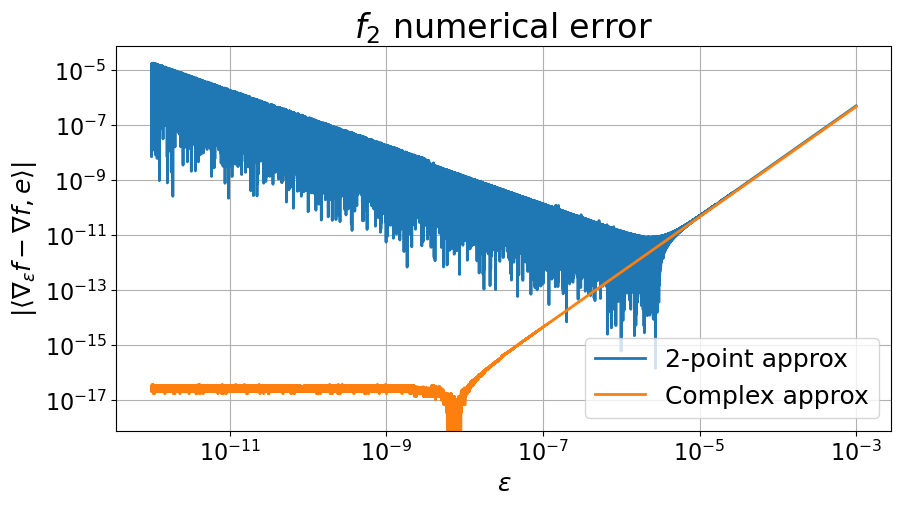

In [ ]:
plt.loglog(eps_range, directional_diffs, label="2-point approx")
plt.loglog(eps_range, im_directional_diffs, label="Complex approx")
plt.legend()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$| \langle\nabla_{\varepsilon}f - \nabla f, e\rangle|$")
plt.title(r"$f_2$ numerical error")
plt.grid();

**Вывод:**

При возможности применения комплексного представления функции данный вид аппроксимации позволяет достичь машинной точности.

Для применения в физике комплексного приближения см. https://provost.utsa.edu/undergraduate-research/journal/files/vol2/UJRSW.Roussel.Millwater.pdf

**Последний комментарий**

Давайте посмотрим на две функции, у которых существуют производные по направлениям, но они не дифференцируемы (т.к. производные не непрерывны).

Попробуем вычислить градиенты по направлению в точке (0, 0) библиотекой autograd и руками с помощью комплексного представления.

In [ ]:
autograd_f3 = grad(f3)
autograd_f4 = grad(f4)

In [ ]:
_point = np.array([0, 0.])

Выберем 8 направлений и посмотрим, какие значения принимает комплексное приближение:

In [ ]:
directions = np.array([[-1, -1.],
                       [0, -1.],
                       [-1, 0],
                       [0, 1],
                       [1, 0],
                       [1, 1],
                       [-1, 1],
                       [1, -1]
                      ])
print("f3 directional derivatives")
for _e in directions:
    print(f"({_e[0]}, {_e[1]}): Complex={df_dir_complex(f3, _point, _e, eps=1e-10):.3f},\
    2-points={df_direction(f3, _point, _e, eps=1e-10):.3f},\
    autograd={autograd_f3(_point).dot(_e):.3f}")

f3 directional derivatives
(-1.0, -1.0): Complex=-1.000,    2-points=0.000,    autograd=0.000
(0.0, -1.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(-1.0, 0.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(0.0, 1.0): Complex=0.000,    2-points=0.000,    autograd=0.000
(1.0, 0.0): Complex=-0.000,    2-points=0.000,    autograd=0.000
(1.0, 1.0): Complex=1.000,    2-points=0.000,    autograd=0.000
(-1.0, 1.0): Complex=-1.000,    2-points=0.000,    autograd=0.000
(1.0, -1.0): Complex=1.000,    2-points=0.000,    autograd=0.000


In [ ]:
print("f4 directional derivatives")
for _e in directions:
    print(f"({_e[0]}, {_e[1]}): Complex={df_dir_complex(f4, _point, _e, eps=1e-10):.3f},\
    2-points={df_direction(f4, _point, _e, eps=1e-10):.3f},\
    autograd={autograd_f4(_point).dot(_e):.3f}")

f4 directional derivatives
(-1.0, -1.0): Complex=0.630,    2-points=nan,    autograd=nan
(0.0, -1.0): Complex=0.500,    2-points=nan,    autograd=nan
(-1.0, 0.0): Complex=0.500,    2-points=nan,    autograd=nan
(0.0, 1.0): Complex=-0.500,    2-points=nan,    autograd=nan
(1.0, 0.0): Complex=-0.500,    2-points=nan,    autograd=nan
(1.0, 1.0): Complex=-0.630,    2-points=nan,    autograd=nan
(-1.0, 1.0): Complex=0.000,    2-points=nan,    autograd=nan
(1.0, -1.0): Complex=0.000,    2-points=nan,    autograd=nan


C:\Users\Georgy\anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


**Вопрос:**

~~Что происходит?~~
- Почему в первом случае комплексное приближение выдаёт такие значения?
- Кто же прав во втором случае?

Ответы:

- В первом случае (как и везде при использовании комплексного приближения), мы хотим, чтобы функция была дифференцируема. Но это не так - в точке 0 данная функция не дифференцируема. Объяснение более подробное, чем словами - [stackexchange](https://math.stackexchange.com/questions/367774/show-that-a-function-has-directional-derivatives-at-a-point-but-is-not-different), [mathinsight](https://mathinsight.org/nondifferentiable_discontinuous_partial_derivatives)

- Во втором случае всё интереснее. Вообще говоря, никто не прав) По идее, частные производные у этой функции в нуле существуют, они равны 1 (см. [stackexchange](https://math.stackexchange.com/questions/673975/function-has-partial-derivatives-but-is-not-differentiable)). Комплексная аппроксимация пытается справиться с их существованием, но беда подходит с другого края - функция не дифференцируема в нуле. ~~Это поражение, с этой утратой никто не справится~~